In [8]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sys import path as sys_path
sys_path.append('/home/jmitchell/software/sunkit-spex-dev/')
from astropy.visualization import quantity_support

from astropy.modeling import fitting
from sunkit_spex.models.physical.albedo import Albedo
from sunkit_spex.models.physical.nonthermal import ThickTarget
from plotting.plotter import plot_fit_results
from sunkit_spex.models.physical.thermal import ThermalEmission
from sunkit_spex.models.scaling import InverseSquareFluxScaling
from sunkit_spex.models.instrument_response import MatrixModel
from sunkit_spex.spectrum.spectrum import SpectralAxis
from sunkit_spex.spectrum.spectrum import Spectrum
from sunkit_spex.extern.stix import STIXLoader

from sunkit_spex.data.simulated_data import simulate_square_response_matrix
from sunkit_spex.fitting.objective_functions.optimising_functions import minimize_func
from sunkit_spex.fitting.optimizer_tools.minimizer_tools import scipy_minimize
from sunkit_spex.fitting.statistics.gaussian import chi_squared
from sunkit_spex.models.instrument_response import MatrixModel
from sunkit_spex.spectrum import Spectrum
from sunkit_spex.spectrum.spectrum import SpectralAxis

from sunkit_spex.models.models import StraightLineModel, GaussianModel


In [89]:
ph_energies_bin_edges = np.linspace(4,80,100)*u.keV
ph_energies_bin_centers = SpectralAxis._centers_from_edges(ph_energies_bin_edges)

count_energies_bin_edges  = ph_energies_bin_edges
count_energies_bin_centers  = ph_energies_bin_centers

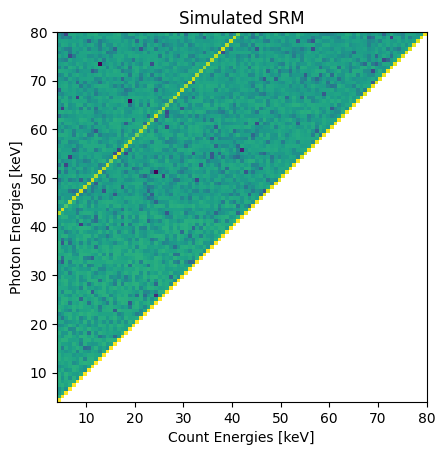

In [90]:
# Define simulated SRM
srm = simulate_square_response_matrix(ph_energies_bin_centers.size)

# Ceate SRM model
srm_model = MatrixModel(
    matrix=srm, input_axis=SpectralAxis(ph_energies_bin_edges), output_axis=SpectralAxis(count_energies_bin_edges), 
    c=1 * u.ct *u.cm**2 * u.ph**-1, 
    _input_units={"x": u.ph *u.keV**-1 *u.s**-1 * u.cm**-2}, 
    _output_units={"y": u.ct* u.keV**-1 * u.s**-1}
)

# Plot the srm matrix
with quantity_support():
    plt.figure()
    plt.imshow(
        srm_model.matrix,
        origin="lower",
        extent=(
            srm_model.input_axis[0].value,
            srm_model.input_axis[-1].value,
            srm_model.output_axis[0].value,
            srm_model.output_axis[-1].value,
        ),
        norm=LogNorm(),
    )
    plt.ylabel(f"Photon Energies [{srm_model.input_axis.unit}]")
    plt.xlabel(f"Count Energies [{srm_model.output_axis.unit}]")
    plt.title("Simulated SRM")
    plt.show()



In [91]:
# Define models
distance = InverseSquareFluxScaling(1*u.AU)
f_vth = ThermalEmission()
thick = ThickTarget(break_energy=1500*u.keV,low_e_cutoff=20*u.keV)
albedo = Albedo(energy_edges=ph_energies_bin_edges, theta=45*u.deg)

# Create composite models
ph_model= (((f_vth + thick) * distance ) | albedo) 
count_model= (((f_vth + thick) * distance ) | albedo)  | srm_model


In [92]:
# Evaluate the models
ph_model_eval = ph_model(ph_energies_bin_edges)
count_model_eval = count_model(ph_energies_bin_edges)

In [93]:
print(ph_model_eval)

[5.79208615e+04 2.09921333e+04 8.28240587e+03 5.19963205e+03
 1.62592079e+03 9.55318031e+02 6.70920475e+02 5.44859182e+02
 4.83467239e+02 4.37682137e+02 4.09527885e+02 3.92281434e+02
 3.81175980e+02 3.66225612e+02 3.52542285e+02 3.47177697e+02
 3.45383653e+02 3.29965867e+02 3.13449839e+02 3.02051619e+02
 2.92078070e+02 2.77985042e+02 2.64810770e+02 2.56721323e+02
 2.48280584e+02 2.36246298e+02 2.25206639e+02 2.15753978e+02
 2.06816316e+02 1.98153294e+02 1.90224496e+02 1.81785827e+02
 1.73664044e+02 1.66418258e+02 1.60727481e+02 1.53340212e+02
 1.47067562e+02 1.41485365e+02 1.36095911e+02 1.30031320e+02
 1.25202684e+02 1.20565099e+02 1.15773689e+02 1.11245569e+02
 1.07120872e+02 1.03124007e+02 9.92514016e+01 9.56001760e+01
 9.21696304e+01 8.89019314e+01 8.57203595e+01 8.25662298e+01
 7.97445825e+01 7.71162822e+01 7.45033414e+01 7.18723014e+01
 6.95360921e+01 6.72540542e+01 6.50320418e+01 6.28469117e+01
 6.06426824e+01 5.87146109e+01 5.66956754e+01 5.46948161e+01
 5.28760031e+01 5.109108

In [94]:
print(count_model_eval)

[5.80870569e+04 2.10090526e+04 8.28197524e+03 5.22643275e+03
 1.65388095e+03 9.95860370e+02 7.18135169e+02 5.79081128e+02
 5.14276117e+02 4.80218008e+02 4.29529479e+02 4.19841308e+02
 4.02651080e+02 3.92199925e+02 3.66341527e+02 3.75578252e+02
 3.66591631e+02 3.41093775e+02 3.31098744e+02 3.13868144e+02
 3.00395266e+02 2.84401810e+02 2.72859567e+02 2.59680961e+02
 2.52293768e+02 2.34570785e+02 2.35828423e+02 2.13590639e+02
 2.11475824e+02 1.95289330e+02 1.87035720e+02 1.79736244e+02
 1.78810098e+02 1.70289822e+02 1.58257027e+02 1.55955835e+02
 1.49523450e+02 1.40091916e+02 1.32545230e+02 1.24682493e+02
 1.22779949e+02 1.17266241e+02 1.16246593e+02 1.11609072e+02
 1.09031080e+02 1.01592549e+02 9.92424936e+01 9.24885753e+01
 8.70793674e+01 8.28785322e+01 6.66911926e+01 4.37154259e+01
 7.09960785e+01 6.06256796e+01 5.07965984e+01 4.05261232e+01
 3.70763470e+01 4.49599267e+01 4.63010893e+01 3.52597503e+01
 4.45425473e+01 3.59265562e+01 4.15530659e+01 3.62768943e+01
 4.53785144e+01 2.604696

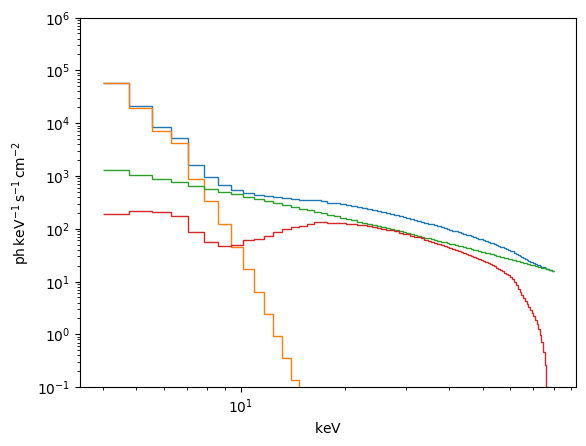

In [95]:
ph_with_albedo = (((f_vth + thick) * distance ) | albedo)(ph_energies_bin_edges) 
ph_without_albedo = ((f_vth+thick)*distance)(ph_energies_bin_edges)

ph_albedo = ph_with_albedo - ph_without_albedo

with quantity_support():
    plt.figure()
    plt.stairs(ph_model_eval,ph_energies_bin_edges,baseline=None)
    plt.stairs((f_vth*distance)(ph_energies_bin_edges),ph_energies_bin_edges,baseline=None)
    plt.stairs((thick*distance)(ph_energies_bin_edges),ph_energies_bin_edges,baseline=None)
    plt.stairs(ph_albedo,ph_energies_bin_edges,baseline=None)
    plt.loglog()
    plt.ylim(1e-1,1e6)

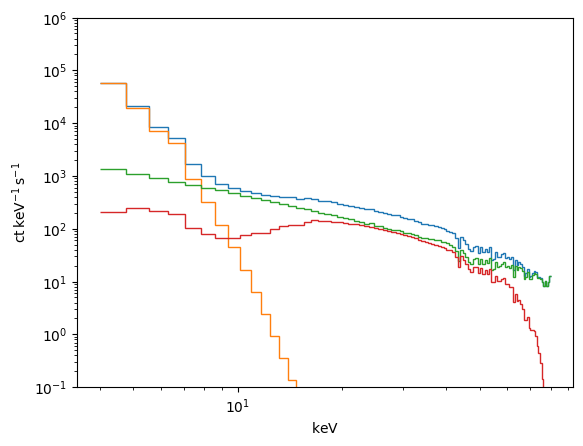

In [96]:
ct_with_albedo = ((((f_vth + thick) * distance ) | albedo)  | srm_model)(ph_energies_bin_edges) 
ct_without_albedo = (((f_vth + thick) * distance )   | srm_model)(ph_energies_bin_edges)

ct_albedo = ct_with_albedo - ct_without_albedo

with quantity_support():
    plt.figure()
    plt.stairs(count_model_eval,count_energies_bin_edges,baseline=None)
    plt.stairs(((f_vth*distance)|srm_model)(ph_energies_bin_edges),count_energies_bin_edges,baseline=None)
    plt.stairs(((thick*distance)|srm_model)(ph_energies_bin_edges),count_energies_bin_edges,baseline=None)
    plt.stairs(ct_albedo,count_energies_bin_edges,baseline=None)
    plt.loglog()
    plt.ylim(1e-1,1e6)